In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn
from datetime import timedelta
import datetime as dt
from sklearn.linear_model import BayesianRidge, LinearRegression, Ridge

%matplotlib inline

# Exploratory Data Analysis

Here we are going to experiment with our data in order to get the most insights possible before building a Machine Learning Model

In [2]:
#import data for the analysis

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
train.head()


,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [3]:
## convert everything to datetime

train['pickup_datetime'] = pd.to_datetime(train.pickup_datetime)
test['pickup_datetime'] = pd.to_datetime( test.pickup_datetime)
train.loc[:, 'pickup_date'] = train['pickup_datetime'].dt.date
test.loc[:, 'pickup_date']  = test['pickup_datetime'].dt.date

## store and fwd flags to boolean

train['store_and_fwd_flag'] = 1 * (train.store_and_fwd_flag.values == 'Y')
test['store_and_fwd_flag'] = 1 * (test.store_and_fwd_flag.values == 'Y')

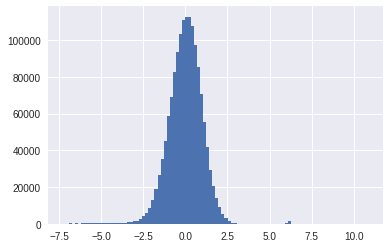

In [4]:
train['log_duration'] = np.log(train['trip_duration'].values + 1)
#maybe also normalize it 
logmean = train['log_duration'].mean()
logstd = train['log_duration'].std()

train['log_duration'] = (train.log_duration - logmean)/logstd

plt.hist(train['log_duration'].values, bins = 100)
plt.show()

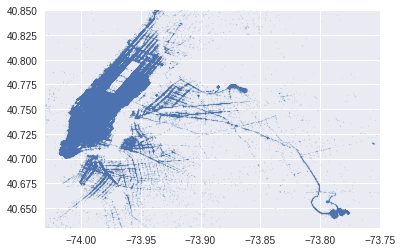

In [5]:
xlim = (-74.03, -73.75)
ylim = (40.63, 40.85)

plt.scatter(train['pickup_longitude'].values, train['pickup_latitude'].values,  s = 1, alpha = 0.1)
plt.xlim(xlim)
plt.ylim(ylim)
plt.show()

In [6]:
def haversine(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    radius = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * radius * np.arcsin(np.sqrt(d))
    return h

def L1_distance(lat1, lng1, lat2, lng2):
    a = haversine(lat1, lng1, lat1, lng2)
    b = haversine(lat1, lng1, lat2, lng1)
    return a + b

In [7]:
train.loc[:, 'haversine'] = haversine(train['pickup_latitude'].values, train['pickup_longitude'].values, train['dropoff_latitude'].values, train['dropoff_longitude'].values)
test.loc[:, 'haversine'] = haversine(test['pickup_latitude'].values, test['pickup_longitude'].values, test['dropoff_latitude'].values, test['dropoff_longitude'].values)

train.loc[:, 'L1_distance'] = L1_distance(train['pickup_latitude'].values, train['pickup_longitude'].values, train['dropoff_latitude'].values, train['dropoff_longitude'].values)
test.loc[:, 'L1_distance'] = L1_distance(test['pickup_latitude'].values, test['pickup_longitude'].values, test['dropoff_latitude'].values, test['dropoff_longitude'].values)

In [8]:
newtrain = train.drop('store_and_fwd_flag', axis = 1)
newtest = test.drop('store_and_fwd_flag', axis = 1)

newtrain.loc[:, 'weekday'] = newtrain.pickup_date.apply(lambda x: x.weekday())
newtest.loc[:, 'weekday'] =newtest.pickup_date.apply(lambda x: x.weekday())

newtrain.loc[:, 'hour'] = newtrain.pickup_datetime.apply(lambda x: x.hour)
newtest.loc[:, 'hour'] = newtest.pickup_datetime.apply(lambda x: x.hour)



newtrain = newtrain.drop('dropoff_datetime', axis = 1)
newtrain = newtrain.drop('vendor_id', axis = 1)
newtest = newtest.drop('vendor_id', axis = 1)
newtrain = newtrain.drop('id', axis = 1)
newtest = newtest.drop('id', axis = 1)
newtrain = newtrain.drop('pickup_date', axis = 1)
newtest = newtest.drop('pickup_date', axis = 1)


ydata = newtrain['log_duration']
newtrain = newtrain.drop('log_duration', axis = 1)
newtrain = newtrain.drop('trip_duration', axis = 1)
newtrain = newtrain.drop('pickup_datetime', axis = 1)
newtest = newtest.drop('pickup_datetime', axis = 1)


## Logtransform L1 - distance and haversine

Here we try to correct the skewness of the L1-distance with a log transorm



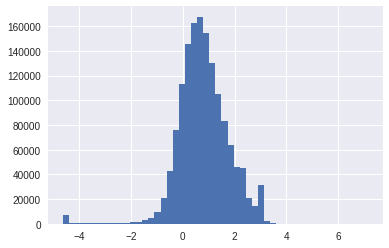

In [9]:
l1train = newtrain['L1_distance'].apply(lambda x: np.log(x + 0.01))
havertrain = newtrain['haversine'].apply(lambda x: np.log(x + 0.01))

havertrain.hist(bins = 50)

Maybe we would like to normalize it in order to have 0 mean and unit standard deviation

In [10]:
newtrain['L1_distance'] = (l1train - l1train.mean())/l1train.std()
newtrain['haversine'] = (havertrain - havertrain.mean())/havertrain.std()

##We do it also for the test data set
l1test = newtest['L1_distance'].apply(lambda x: np.log(x + 0.01))
havertest = newtest['haversine'].apply(lambda x: np.log(x + 0.01))
newtest['L1_distance'] = (l1test -l1test.mean())/l1test.std()
newtest['haversine'] = (havertest - havertest.mean())/havertest.std()

Lets plot this histogram together with the log trip duration to see if we are going to have some correlation

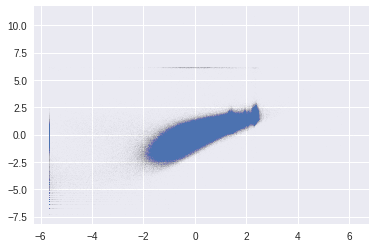

In [11]:
plt.scatter(newtrain['L1_distance'], ydata, s = 1, alpha = 0.002)

In [12]:
#pickuplat = newtrain['pickup_latitude'].apply(lambda x: np.log(x))
#pickuplat = (pickuplat - pickuplat.mean())/pickuplat.std()
#newtrain['pickup_latitude'] = pickuplat
#pickuplong = newtrain['pickup_longitude'].apply(lambda x: np.log(-x))
#pickuplong = (pickuplong - pickuplong.mean())/pickuplong.std()
#newtrain['pickup_longitude'] = pickuplong

#pickuplat2 = newtest['pickup_latitude'].apply(lambda x: np.log(x))
#pickuplat2 = (pickuplat2 - pickuplat2.mean())/pickuplat2.std()
#newtest['pickup_latitude'] = pickuplat2
#pickuplong2 = newtest['pickup_longitude'].apply(lambda x: np.log(-x))
#pickuplong2 = (pickuplong2 - pickuplong2.mean())/pickuplong2.std()
#newtest['pickup_longitude'] = pickuplong2


that looks like correlation, now lets do one hot encoding on the weekday and hour because thats more of a categorical value and not numerical in nature. 

In [13]:
weektrain = pd.get_dummies(newtrain['weekday'])
weektrain.columns = ['m','t','w', 'th', 'f', 's', 'su']
hourstrain = pd.get_dummies(newtrain['hour'])

weektest = pd.get_dummies(newtest['weekday'])
weektest.columns = ['m','t','w', 'th', 'f', 's', 'su']
hourstest = pd.get_dummies(newtest['hour'])


now lets create a dataframe with the values that we want to really use for regression

In [14]:
Xdata = pd.concat([newtrain['haversine'], train['trip_duration'], newtrain['L1_distance'],newtrain['passenger_count'], weektrain, hourstrain], axis = 1)
ydata = ydata

#,newtrain['pickup_latitude'],newtrain['pickup_longitude']
Xsub = pd.concat([newtest['haversine'],newtest['passenger_count'], newtest['L1_distance'],  weektest, hourstest], axis = 1)

These are functions for regression that we are going to need in the future, we are also including a delog function.

In [15]:

def getCoefs(x, y):
    x = np.asmatrix(x.values)
    y = np.asmatrix(y.values)
    return np.linalg.inv(x.T.dot(x)).dot(x.T).dot(y)

def performRegression(x, y, _details=False):
    coefs = getCoefs(x,y)
    estimate = np.asmatrix(x.values).dot(coefs)
    error_vect = (y-estimate).values
    if _details:
        return pd.DataFrame(estimate), {'error_vect':error_vect,'mse':np.mean(np.square(error_vect)),'coefs':coefs}
    return pd.DataFrame(estimate)

def delog(y, mean, std):
    res = y*std + mean
    res = np.exp(res) + 0.01
    return res

def rmsle(predicted, real):
    """Root mean square logarithmic error."""
    sum = 0.0
    for x in range(len(predicted)):
        p = np.log(predicted[x]+1)
        r = np.log(real[x]+1)
        sum = sum + (p - r)**2
    return np.sqrt(sum/len(predicted))
        

Now lets try  to do a basic linear regression

##first the coefficients of the linear function

#coefs = getCoefs(Xtrain, pd.DataFrame(ytrain))

#regression = lambda x: np.asmatrix(x.values).dot(coefs)

#ytest = regression(Xtest)

#ytest = delog(ytest, logmean, logstd)

reg = Ridge(alpha = 0.5)
reg.fit(Xtrain.as_matrix(), ytrain.as_matrix())

In [16]:
## CROSS VALIDATION
from sklearn.model_selection import train_test_split

Xtrain, Xtest, ytrain, ytest = train_test_split(Xdata.as_matrix(), ydata.as_matrix(), test_size = 0.4, random_state = 0)
##removing the time for training

Xtraintime = Xtrain[:,1]
Xtesttime = Xtest[:,1]
Xtrain = np.delete(Xtrain, 1, axis = 1)
Xtest = np.delete(Xtest, 1, axis =  1)

In [17]:
## MATRICES FOR REGRESSION

from sklearn import linear_model

etrain = []
etest = []

for cons in [0.001, 0.01, 0.1, 1, 10,100]:
    reg = linear_model.Ridge(alpha = cons)
    reg.fit(Xtrain, ytrain)
    
    ypredlogtrain = reg.predict(Xtrain)
    ypredlogtrain = np.array(ypredlogtrain).reshape((len(ypredlogtrain, )))
    ypredtrain = delog(ypredlogtrain, logmean, logstd)
    
    errortrain = rmsle(ypredtrain.reshape((len(ypredtrain,))), Xtraintime)
    etrain.append(errortrain)
    
    ypredlogtest = reg.predict(Xtest)
    ypredlogtest = np.array(ypredlogtest).reshape((len(ypredlogtest, )))
    ypredtest = delog(ypredlogtest, logmean, logstd)
    
    errortest = rmsle(ypredtest.reshape((len(ypredtest,))), Xtesttime)
    etest.append(errortest)

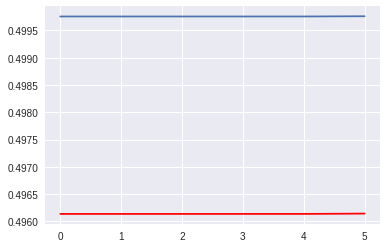

In [18]:
plt.plot(etrain)
plt.plot(etest, color = 'red')
plt.show()

What about the logarithmic error of the aactual train function

In [19]:
from sklearn import linear_model

reg = linear_model.Ridge(alpha = 0.1)
reg.fit(Xtrain, ytrain)
    
ypredlog = reg.predict(Xsub)
ypredlog = np.array(ypredlog).reshape((len(ypredlog, )))
ypred = delog(ypredlog, logmean, logstd)

plt.scatter(ytrainpredlog, ytrain, s= 1, alpha = 0.1)

In [20]:
submission = pd.concat([test['id'],pd.DataFrame(ypred)], axis = 1)
submission.columns = ['id', 'trip_duration']
submission.to_csv('submission.csv', index = False)

In [21]:
test['id'].as_matrix().shape

(625134,)